# The TikTok-to-Spotify Pipeline
**TXC Group X**<br>
Leticia Brendle - 70033 <br>
Francesco Ciorciolini - 73166 <br>
X<br>


Repository: https://github.com/letti70033/spotify-tiktok-analysis

### [1. Executive Summary](#1-executive-summary)

### [2. Introduction](#2-introduction)
- [2.1 Dataset Description](#21-dataset-description)
- [2.2 Research Question](#22-research-question)  
- [2.3 Hypotheses](#23-hypotheses)
- [2.4 Analysis Plan](#24-analysis-plan)

### [3. Exploratory Data Analysis](#3-exploratory-data-analysis)
- [3.1 Data Set Up](#31-data-set-up)
- [3.2 Data Cleaning](#32-data-cleaning)
  - [3.2.1 Drop unnecessary columns](#321-drop-unnecessary-columns)
  - [3.2.2 Remove missing values](#322-remove-missing-values)
  - [3.2.3 Remove duplicates](#323-remove-duplicates)
- [3.3 Variables](#33-variables)
- [3.4 Descriptive Statistics](#34-descriptive-statistics)
  - [3.4.1 Measures of central tendency](#341-measures-of-central-tendency)
  - [3.4.2 Correlations](#342-correlations)
  - [3.4.3 Summary Statistics Table](#343-summary-statistics-table)
- [3.5 Key Findings](#35-key-findings)

### [4. Method 1: Polynomial Regression](#4-method-1-polynomial-regression)

### [5. Method 2: Threshold Analysis](#5-method-2-threshold-analysis)

### [6. Reflection on AI Use](#6-reflection-on-ai-use)

### [7. Conclusion](#7-conclusion)

*notes from prof (sheet):*
The Notebook must include at least the following sections:
1. Executive Summary – A short summary that highlights the goal of the project and core findings.
2. Introduction – A section that describes (in words) the dataset and variables. This section should
clearly state the research question(s) and the related hypotheses and describe a plan to test them.
3. Exploratory data analysis – A section that uses different statistical metrics and visualizations to
describe the data set and presents the first descriptive insights.


3.1 Types of variables
3.2 Descriptive Statistics
3.2.1 Frequencies
3.2.2 Measures of central tendency
3.2.3 Correlations
3.2.4 Summary statistics table

4. Method 1 – This section should describe why a specific method (e.g., t-test, linear regression,
logistic regression, cluster analysis, factor analysis, time series model, or panel regression) is used
to test a hypothesis. It should apply the method to the data set, check the most important
assumptions, and provide an interpretation of the results obtained (i.e., what did we learn about
the hypotheses, and how good is the model).
5. Method 2 – This section should contain the same information as the previous section, but with
another method to test a different hypothesis.
6. Reflection on use of AI – This section is dedicated to discussing the use of AI, should detail what
AI models were used, for what tasks AI was used, how it was used (e.g., prompt examples), and
what value the students contributed beyond the tasks the AI completed (e.g., what instructions
were crucial to improve the quality of the project, what approaches did not work, etc.).
7. Conclusion – This section should discuss the findings and explain what we learned about the
research question. Further, it should discuss the chosen approach's limitations and ways to
improve the analysis.

## 1. Executive Summary

## 2. Introduction



### 2.1 Dataset Description
The dataset used in this project comes from <i> Spotify’s most streamed songs in 2024</i>, enriched with information related to TikTok activity and popularity metrics. It includes both musical characteristics, such as streams and popularity on Spotify) and social media engagement indicators, as TikTok posts, likes, and views. This combination allows us to analyze the relationship between streaming platforms and social media virality, in particular Spotify and TikTok respectively.

#### Play Story Data Set
**Track** : The title of the song<br>
**Artist** : The artist(s) of the song<br>
**Release Date** : The official release date of the track<br>
**Spotify Streams** : The total number of times the song has been streamed on Spotify<br>
**Spotify Popularity** : A numerical score (0–100) assigned by Spotify, which reflects both recent and historical streaming activity<br>
**Spotify Playlist Count** : The number of playlists on Spotify that include the track<br>
**TikTok Posts** : The number of TikTok videos created using the song as background music<br>
**TikTok Likes** : The total number of likes received by TikTok videos featuring the song<br>
**TikTok Views** : The total number of views generated by TikTok videos using the track<br>
**Track Score** : A composite score that combines multiple dimensions of success (streams, TikTok metrics, popularity) to give an overall performance indicator<br>
**All Time Rank** : The position of the track in the ranking of Spotify’s most streamed songs of all time<br>



### 2.2 Research Question
The goal of this research is to better understand the question:
#### **Does TikTok virality create a 'popularity ceiling' effect? Investigating how TikTok engagement patterns predict and limit long-term streaming success across Spotify.**
To answer this question, we have formulated two hypotheses which will be tested:

*Why Novel: Tests the counterintuitive idea that TikTok success might actually limit rather than enhance long-term success*
*Business Relevance: Critical for music industry investment and artist development strategies*



### 2.3 Hypotheses

#### Hypothesis 1: Songs with extremely high TikTok engagement (top 10%) show diminishing returns on Spotify long-term streaming compared to moderate TikTok performers
- **Null Hypothesis (H₀):** .
- **Alternative Hypothesis (H₁):** .


<br>

#### Hypothesis 2: Higher Sentiment Polarity has stronger influence on the average Rating in some Categories 
- **Null Hypothesis (H₀):** .
- **Alternative Hypothesis (H₁):**  .



*Methods: Polynomial regression to test non-linear relationships + threshold analysis for identifying optimal TikTok engagement levels -> see if we use this methods!!*



### 2.4 Analysis Plan

## 3. Data Setup



### 3.1 Import libraries and data
First we will import all the necessary libraries as well as our data sets. We will also have a first look at the structure of the data to help us understand it.

In [132]:
# Import libraries
# Data
import pandas as pd 
import numpy as np

# Graphs
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV file 
spotify_songs = pd.read_csv('Most Streamed Spotify Songs 2024.csv', encoding='cp1252')

# Data Overview 
print(spotify_songs.head())
print(f"Dataset size: {spotify_songs.shape[0]} rows, {spotify_songs.shape[1]} columns")


                        Track                    Album Name          Artist  \
0         MILLION DOLLAR BABY  Million Dollar Baby - Single   Tommy Richman   
1                 Not Like Us                   Not Like Us  Kendrick Lamar   
2  i like the way you kiss me    I like the way you kiss me         Artemas   
3                     Flowers              Flowers - Single     Miley Cyrus   
4                     Houdini                       Houdini          Eminem   

  Release Date          ISRC All Time Rank  Track Score Spotify Streams  \
0    4/26/2024  QM24S2402528             1        725.4     390,470,936   
1     5/4/2024  USUG12400910             2        545.9     323,703,884   
2    3/19/2024  QZJ842400387             3        538.4     601,309,283   
3    1/12/2023  USSM12209777             4        444.9   2,031,280,633   
4    5/31/2024  USUG12403398             5        423.3     107,034,922   

  Spotify Playlist Count Spotify Playlist Reach  ...  SiriusXM Spins  \
0 

### 3.2 Data Cleaning

clean data


#### 3.2.1 Drop unnecessary columns
After our preparing the data we now remove all unnecessary columns. This ensures that we can focus on the variables that are relevant for our analysis while also making our data set smaller which speeds up the analysis.
#### we dont need columns: X, just:'Track', 'Artist', 'Release Date', 'Spotify Streams', 'Spotify Popularity', 'Spotify Playlist Count', 'TikTok Posts', 'TikTok Likes', 'TikTok Views', 'Track Score', 'All Time Rank'

In [133]:

# define TikTok-to-Spotify relevant columns
relevant_columns = [
    'Track', 'Artist', 'Release Date',
    'Spotify Streams', 'Spotify Popularity', 'Spotify Playlist Count', 
    'TikTok Posts', 'TikTok Likes', 'TikTok Views',
    'Track Score', 'All Time Rank'
]

print(f"Keeping {len(relevant_columns)} relevant columns from {spotify_songs.shape[1]} total columns:")
for col in relevant_columns:
    print(f"  • {col}")

# drop other columns
songs_clean_columns = spotify_songs[relevant_columns].copy()

#overview of data with relevant columns
print(songs_clean_columns.head())
print(f"\nDataset after dropping columns: {songs_clean_columns.shape[0]} rows, {songs_clean_columns.shape[1]} columns")


Keeping 11 relevant columns from 29 total columns:
  • Track
  • Artist
  • Release Date
  • Spotify Streams
  • Spotify Popularity
  • Spotify Playlist Count
  • TikTok Posts
  • TikTok Likes
  • TikTok Views
  • Track Score
  • All Time Rank
                        Track          Artist Release Date Spotify Streams  \
0         MILLION DOLLAR BABY   Tommy Richman    4/26/2024     390,470,936   
1                 Not Like Us  Kendrick Lamar     5/4/2024     323,703,884   
2  i like the way you kiss me         Artemas    3/19/2024     601,309,283   
3                     Flowers     Miley Cyrus    1/12/2023   2,031,280,633   
4                     Houdini          Eminem    5/31/2024     107,034,922   

   Spotify Popularity Spotify Playlist Count TikTok Posts   TikTok Likes  \
0                92.0                 30,716    5,767,700    651,565,900   
1                92.0                 28,113      674,700     35,223,547   
2                92.0                 54,331    3,025,400  

#### 3.2.2 Remove missing values

find and remove missing values + make all data to coherent types

In [134]:

# see how many/where missing values there are
missing_summary = songs_clean_columns.isnull().sum()
missing_percentage = (missing_summary / len(songs_clean_columns)) * 100

print("Missing values per column:")
for col in songs_clean_columns.columns:
    missing_count = missing_summary[col]
    missing_pct = missing_percentage[col]
    print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")

# identify numeric columns
numeric_columns = [
    'Spotify Streams', 'Spotify Popularity', 'Spotify Playlist Count',
    'TikTok Posts', 'TikTok Likes', 'TikTok Views', 
    'Track Score', 'All Time Rank'
]

# convert string numbers to int
for col in numeric_columns:
    if col in songs_clean_columns.columns:
        # remove , 
        songs_clean_columns[col] = songs_clean_columns[col].astype(str).str.replace(',', '').str.replace(' ', '')
        songs_clean_columns[col] = pd.to_numeric(songs_clean_columns[col], errors='coerce')

# Release Date to datetime
songs_clean_columns['Release Date'] = pd.to_datetime(songs_clean_columns['Release Date'], errors='coerce')

# Drop rows with missing values+ Overview
bef_mis_values = len(songs_clean_columns)
print(f"\nRows before dropping missing values: {bef_mis_values}")
songs_clean_missing_na = songs_clean_columns.dropna()
aft_mis_values = len(songs_clean_missing_na)
print(f"Rows after dropping missing values: {aft_mis_values}")
print(f"Total number of missing values dropped: {bef_mis_values-aft_mis_values}")



Missing values per column:
  Track: 0 (0.0%)
  Artist: 5 (0.1%)
  Release Date: 0 (0.0%)
  Spotify Streams: 113 (2.5%)
  Spotify Popularity: 804 (17.5%)
  Spotify Playlist Count: 70 (1.5%)
  TikTok Posts: 1173 (25.5%)
  TikTok Likes: 980 (21.3%)
  TikTok Views: 981 (21.3%)
  Track Score: 0 (0.0%)
  All Time Rank: 0 (0.0%)

Rows before dropping missing values: 4600
Rows after dropping missing values: 3171
Total number of missing values dropped: 1429


#### 3.3.3 Remove Duplicates

Checking for duplicates based on Track + Artist combination

In [135]:

#check for duplictes based on Track + Artist combination
duplicates_before = songs_clean_missing_na.duplicated(subset=['Track', 'Artist']).sum()
bef_dupl = len(songs_clean_missing_na)

print(f"Duplicate songs found: {duplicates_before}")

if duplicates_before > 0:
    
    print("\nDuplicated songs:")
    duplicate_songs = songs_clean_missing_na[songs_clean_missing_na.duplicated(subset=['Track', 'Artist'], keep=False)]
    duplicate_examples = duplicate_songs.groupby(['Track', 'Artist']).size().head()
    for (track, artist), count in duplicate_examples.items():
        print(f"  '{track}' by {artist}: {count} entries")
    
    # drop duplicates
    bef_dupl = len(songs_clean_missing_na)
    songs_clean_duplicates = songs_clean_missing_na.drop_duplicates(subset=['Track', 'Artist'], keep='first')
    aft_dupl = len(songs_clean_duplicates)
else:
    print("No duplicates found!")


# Overview of dropped duplicates
duplicates_after = songs_clean_duplicates.duplicated(subset=['Track', 'Artist']).sum()
print(f"Remaining duplicates after dropping: {duplicates_after}")
print(f"\nRows before dropping duplicateds: {bef_dupl}")
print(f"Rows after dropping duplictes: {aft_dupl}")
print(f"Total number of duplicates dropped: {bef_dupl - aft_dupl}")

# Save cleaned dataset
songs_clean_duplicates.to_csv('spotify_cleaned.csv', index=False)
print(f"\nCleaned dataset saved as 'spotifysongs_cleaned.csv'")

Duplicate songs found: 12

Duplicated songs:
  'Bad and Boujee (feat. Lil Uzi Vert)' by Migos: 2 entries
  'Cheap Thrills' by Sia: 2 entries
  'Dembow' by Danny Ocean: 2 entries
  'Let Her Go' by Passenger: 2 entries
  'Me Rehï¿½ï' by Danny Ocean: 2 entries
Remaining duplicates after dropping: 0

Rows before dropping duplicateds: 3171
Rows after dropping duplictes: 3159
Total number of duplicates dropped: 12

Cleaned dataset saved as 'spotifysongs_cleaned.csv'


Explain that we focus on 4 variables: Spotify Streams, Spotify Popularity, Tik Tok Views and Tik Tok Likes

streams-> views the most comparable one

## 4 Exploratory Data Analysis (EDA)

### 4.1 Types of variables in our dataset

In [2]:
spotify_songs = pd.read_csv('spotify_cleaned.csv')
spotify_songs.columns = spotify_songs.columns.str.replace(' ', '_')
spotify_songs.dtypes

NameError: name 'pd' is not defined

In [ ]:
spotify_songs.columns

Index(['Track', 'Artist', 'Release_Date', 'Spotify_Streams',
       'Spotify_Popularity', 'Spotify_Playlist_Count', 'TikTok_Posts',
       'TikTok_Likes', 'TikTok_Views', 'Track_Score', 'All_Time_Rank'],
      dtype='object')

#### 4.1.1 Nominal, ordinal and binary variables

In [ ]:
print(spotify_songs.Track.unique())
print(spotify_songs.Artist.unique())
print(spotify_songs.Release_Date.unique())
print(spotify_songs.All_Time_Rank.unique())

['MILLION DOLLAR BABY' 'Not Like Us' 'i like the way you kiss me' ...
 'Grace (feat. 42 Dugg)' 'Nashe Si Chadh Gayi'
 'Me Acostumbre (feat. Bad Bunny)']
['Tommy Richman' 'Kendrick Lamar' 'Artemas' ... 'Ed Maverick' 'SR'
 'Kerim Araz']
['2024-04-26' '2024-05-04' '2024-03-19' ... '2023-03-06' '2016-11-08'
 '2017-04-11']
[   1    2    3 ... 4571 4591 4593]


#### 4.1.2 Continous variables

In [ ]:
print('Spotify_Streams')
print(spotify_songs.Spotify_Streams.min())
print(spotify_songs.Spotify_Streams.max())

print('Spotify_Popularity')
print(spotify_songs.Spotify_Popularity.min())
print(spotify_songs.Spotify_Popularity.max())

print('TikTok_Views')
print(spotify_songs.TikTok_Views.min())
print(spotify_songs.TikTok_Views.max())

print('TikTok_Likes')
print(spotify_songs.TikTok_Likes.min())
print(spotify_songs.TikTok_Likes.max())





Spotify_Streams
3574.0
4281468720.0
Spotify_Popularity
1.0
95.0
TikTok_Views
385.0
233232311463.0
TikTok_Likes
20.0
23474223833.0


### 3.4 Descriptive Statistics

##### Empirical cumulative distribution function (ECDF)

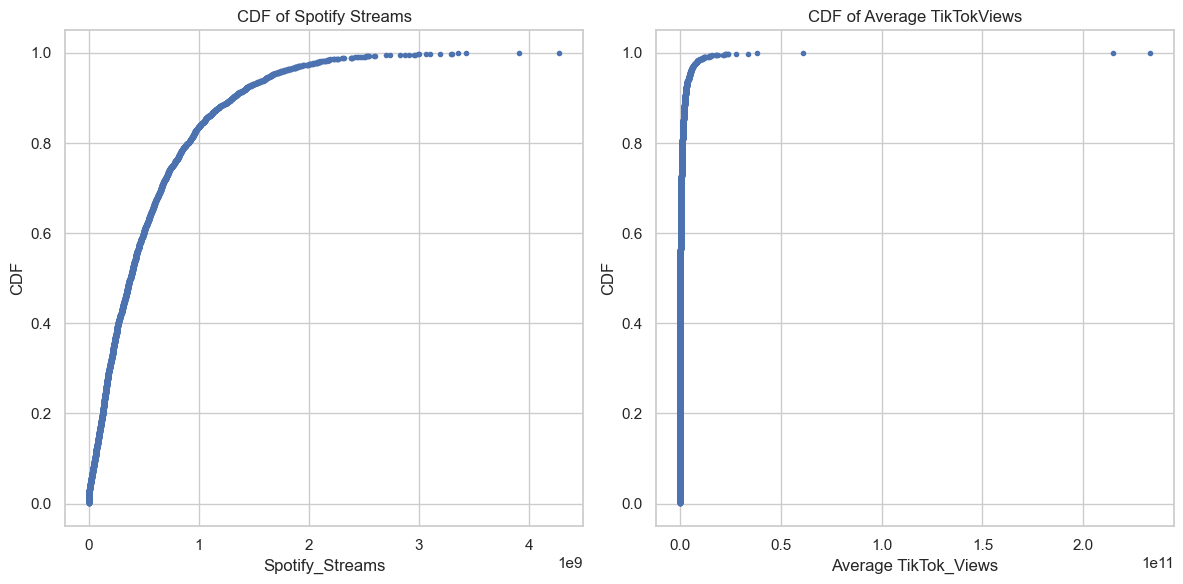

In [140]:
# cumulative distribution plot for 'Spotify_Streams' and 'TikTok_Views'

# Plotting the CDF for Satisfaction
plt.figure(figsize=(12, 6))

# CDF for Satisfaction
plt.subplot(1, 2, 1)
spotify_sorted = np.sort(spotify_songs['Spotify_Streams'])
spotify_cdf = np.arange(1, len(spotify_sorted) + 1) / len(spotify_sorted)
plt.plot(spotify_sorted, spotify_cdf, marker='.', linestyle='none')
plt.title('CDF of Spotify Streams')
plt.xlabel('Spotify_Streams')
plt.ylabel('CDF')
plt.grid(True)

# CDF for TikTok Views
plt.subplot(1, 2, 2)
tiktok_sorted = np.sort(spotify_songs['TikTok_Views'])
tiktok_cdf = np.arange(1, len(tiktok_sorted) + 1) / len(tiktok_sorted)
plt.plot(tiktok_sorted, tiktok_cdf, marker='.', linestyle='none')
plt.title('CDF of Average TikTokViews')
plt.xlabel('Average TikTok_Views')
plt.ylabel('CDF')
plt.grid(True)

plt.tight_layout()
plt.show()

Interpretations:

Both platforms exhibit extreme right-skew, with TikTok showing a more pronounced winner-takes-all dynamic.

90% of songs cluster below the viral threshold, suggesting success concentration in top decile.

Log-transformation recommended for regression analysis due to power-law distribution.

Outliners are seen.



#### 3.4.1 Measures of central tendency

##### Minimunm, maxinum and range

In [141]:

# Spotify Streams
min_spotify_streams = spotify_songs['Spotify_Streams'].min()
max_spotify_streams = spotify_songs['Spotify_Streams'].max()
range_spotify_streams = max_spotify_streams - min_spotify_streams

# Spotify Popularity
min_spotify_popularity = spotify_songs['Spotify_Popularity'].min()
max_spotify_popularity = spotify_songs['Spotify_Popularity'].max()
range_spotify_popularity = max_spotify_popularity - min_spotify_popularity

# TikTok Likes
min_tiktok_likes = spotify_songs['TikTok_Likes'].min()
max_tiktok_likes = spotify_songs['TikTok_Likes'].max()
range_tiktok_likes = max_tiktok_likes - min_tiktok_likes

# TikTok Views
min_tiktok_views = spotify_songs['TikTok_Views'].min()
max_tiktok_views = spotify_songs['TikTok_Views'].max()
range_tiktok_views = max_tiktok_views - min_tiktok_views


# Print the results
print("\nSpotify Streams:")
print(f" Min: {min_spotify_streams:,.0f}")
print(f" Max: {max_spotify_streams:,.0f}")
print(f" Range: {range_spotify_streams:,.0f}\n")

print("Spotify Popularity:")
print(f" Min: {min_spotify_popularity}")
print(f" Max: {max_spotify_popularity}")
print(f" Range: {range_spotify_popularity}\n")

print("TikTok Likes:")
print(f" Min: {min_tiktok_likes:,.0f}")
print(f" Max: {max_tiktok_likes:,.0f}")
print(f" Range: {range_tiktok_likes:,.0f}\n")

print("TikTok Views:")
print(f" Min: {min_tiktok_views:,.0f}")
print(f" Max: {max_tiktok_views:,.0f}")
print(f" Range: {range_tiktok_views:,.0f}\n")



Spotify Streams:
 Min: 3,574
 Max: 4,281,468,720
 Range: 4,281,465,146

Spotify Popularity:
 Min: 1.0
 Max: 95.0
 Range: 94.0

TikTok Likes:
 Min: 20
 Max: 23,474,223,833
 Range: 23,474,223,813

TikTok Views:
 Min: 385
 Max: 233,232,311,463
 Range: 233,232,311,078



##### Mean, median, mode, quantiles 

In [142]:

# Spotify Streams
mean_spotify_streams = spotify_songs['Spotify_Streams'].mean()
median_spotify_streams = spotify_songs['Spotify_Streams'].median()
q25_spotify_streams = spotify_songs['Spotify_Streams'].quantile(0.25)
q75_spotify_streams = spotify_songs['Spotify_Streams'].quantile(0.75)
mode_spotify_streams = spotify_songs['Spotify_Streams'].mode()

# Spotify Popularity
mean_spotify_popularity = spotify_songs['Spotify_Popularity'].mean()
median_spotify_popularity = spotify_songs['Spotify_Popularity'].median()
q25_spotify_popularity = spotify_songs['Spotify_Popularity'].quantile(0.25)
q75_spotify_popularity = spotify_songs['Spotify_Popularity'].quantile(0.75)
mode_spotify_popularity = spotify_songs['Spotify_Popularity'].mode()

# TikTok Likes
mean_tiktok_likes = spotify_songs['TikTok_Likes'].mean()
median_tiktok_likes = spotify_songs['TikTok_Likes'].median()
q25_tiktok_likes = spotify_songs['TikTok_Likes'].quantile(0.25)
q75_tiktok_likes = spotify_songs['TikTok_Likes'].quantile(0.75)
mode_tiktok_likes = spotify_songs['TikTok_Likes'].mode()

# TikTok Views
mean_tiktok_views = spotify_songs['TikTok_Views'].mean()
median_tiktok_views = spotify_songs['TikTok_Views'].median()
q25_tiktok_views = spotify_songs['TikTok_Views'].quantile(0.25)
q75_tiktok_views = spotify_songs['TikTok_Views'].quantile(0.75)
mode_tiktok_views = spotify_songs['TikTok_Views'].mode()

# Print the results
print("\nSpotify Streams:")
print(f" Mean: {mean_spotify_streams:,.0f}")
print(f" Median: {median_spotify_streams:,.0f}")
print(f" 25th percentile: {q25_spotify_streams:,.0f}")
print(f" 75th percentile: {q75_spotify_streams:,.0f}")
print(f" Mode: {mode_spotify_streams.values[0] if len(mode_spotify_streams) > 0 else 'N/A'}\n")

print("Spotify Popularity:")
print(f" Mean: {mean_spotify_popularity:.2f}")
print(f" Median: {median_spotify_popularity}")
print(f" 25th percentile: {q25_spotify_popularity}")
print(f" 75th percentile: {q75_spotify_popularity}")
print(f" Mode: {mode_spotify_popularity.values[0] if len(mode_spotify_popularity) > 0 else 'N/A'}\n")

print("TikTok Likes:")
print(f" Mean: {mean_tiktok_likes:,.0f}")
print(f" Median: {median_tiktok_likes:,.0f}")
print(f" 25th percentile: {q25_tiktok_likes:,.0f}")
print(f" 75th percentile: {q75_tiktok_likes:,.0f}")
print(f" Mode: {mode_tiktok_likes.values[0] if len(mode_tiktok_likes) > 0 else 'N/A'}\n")

print("TikTok Views:")
print(f" Mean: {mean_tiktok_views:,.0f}")
print(f" Median: {median_tiktok_views:,.0f}")
print(f" 25th percentile: {q25_tiktok_views:,.0f}")
print(f" 75th percentile: {q75_tiktok_views:,.0f}")
print(f" Mode: {mode_tiktok_views.values[0] if len(mode_tiktok_views) > 0 else 'N/A'}\n")



Spotify Streams:
 Mean: 548,381,032
 Median: 380,367,132
 25th percentile: 155,910,223
 75th percentile: 764,516,486
 Mode: 860026452.0

Spotify Popularity:
 Mean: 64.55
 Median: 67.0
 25th percentile: 61.0
 75th percentile: 72.0
 Mode: 67.0

TikTok Likes:
 Mean: 122,043,768
 Median: 32,754,141
 25th percentile: 8,802,372
 75th percentile: 104,916,247
 Mode: 20.0

TikTok Views:
 Mean: 1,249,346,753
 Median: 312,937,612
 25th percentile: 85,415,826
 75th percentile: 1,025,391,896
 Mode: 385.0



##### Variance and Standard Deviation 

In [143]:

# Compute variance and standard deviation for Spotify Streams
spotify_streams_variance = spotify_songs['Spotify_Streams'].var()
spotify_streams_std_dev = spotify_songs['Spotify_Streams'].std()

# Compute variance and standard deviation for Spotify Popularity
spotify_popularity_variance = spotify_songs['Spotify_Popularity'].var()
spotify_popularity_std_dev = spotify_songs['Spotify_Popularity'].std()

# Compute variance and standard deviation for TikTok Views
tiktok_views_variance = spotify_songs['TikTok_Views'].var()
tiktok_views_std_dev = spotify_songs['TikTok_Views'].std()

# Compute variance and standard deviation for TikTok Likes
tiktok_likes_variance = spotify_songs['TikTok_Likes'].var()
tiktok_likes_std_dev = spotify_songs['TikTok_Likes'].std()

# Print the results
print("\nSpotify Streams:")
print(f" Variance: {spotify_streams_variance:.2e}")
print(f" Standard Deviation: {spotify_streams_std_dev:,.0f}\n")

print("Spotify Popularity:")
print(f" Variance: {spotify_popularity_variance:.2f}")
print(f" Standard Deviation: {spotify_popularity_std_dev:.2f}\n")

print("TikTok Views:")
print(f" Variance: {tiktok_views_variance:.2e}")
print(f" Standard Deviation: {tiktok_views_std_dev:,.0f}\n")

print("TikTok Likes:")
print(f" Variance: {tiktok_likes_variance:.2e}")
print(f" Standard Deviation: {tiktok_likes_std_dev:,.0f}")




Spotify Streams:
 Variance: 2.95e+17
 Standard Deviation: 543,027,720

Spotify Popularity:
 Variance: 188.84
 Standard Deviation: 13.74

TikTok Views:
 Variance: 3.85e+19
 Standard Deviation: 6,205,640,960

TikTok Likes:
 Variance: 3.37e+17
 Standard Deviation: 580,258,424


##### Skewness, Kurtosis and transformations

**Skewness**

Skewness = 0: Then normally distributed. <br>
Skewness > 0: Then more weight in the left tail of the distribution. <br>
Skewness < 0: Then more weight in the right tail of the distribution. <br>


**Kurtosis**

kurtosis for normal distribution is equal to 3. <br>
For a distribution having kurtosis < 3: It is called playkurtic (fewer observations on the tail/s). <br>
For a distribution having kurtosis > 3, It is called leptokurtic and it signifies that it tries to produce more outliers rather than the normal distribution. <br>

In [144]:
from scipy.stats import skew 
from scipy.stats import kurtosis 

# Spotify Streams
print("\nSpotify Streams:")
print('skewness:', str(skew(spotify_songs.Spotify_Streams, axis=0, bias=True)))
print('kurtosis:', str(kurtosis(spotify_songs.Spotify_Streams, axis=0, bias=True)))

# Spotify Popularity
print("\nSpotify Popularity:")
print('skewness:', str(skew(spotify_songs.Spotify_Popularity, axis=0, bias=True)))
print('kurtosis:', str(kurtosis(spotify_songs.Spotify_Popularity, axis=0, bias=True)))

# TikTok Views
print("\nTikTok Views:")
print('skewness:', str(skew(spotify_songs.TikTok_Views, axis=0, bias=True)))
print('kurtosis:', str(kurtosis(spotify_songs.TikTok_Views, axis=0, bias=True)))

# TikTok Likes
print("\nTikTok Likes:")
print('skewness:', str(skew(spotify_songs.TikTok_Likes, axis=0, bias=True)))
print('kurtosis:', str(kurtosis(spotify_songs.TikTok_Likes, axis=0, bias=True)))



Spotify Streams:
skewness: 1.7660514654543653
kurtosis: 4.033604943636715

Spotify Popularity:
skewness: -2.220132197547876
kurtosis: 6.652204427263264

TikTok Views:
skewness: 30.09338633670805
kurtosis: 1064.2096243962433

TikTok Likes:
skewness: 31.079760302337146
kurtosis: 1143.94972436616


REDOOOO:

Tik Tok much stronger skewed

We can confirm this by looking at out kernel density plot

But what can we do about this?

We could try to transform the variable. 

One of the the most common transformations is the log or ln transformation. 


In [145]:

# TikTok Views transformations
spotify_songs['TikTok_Views_log2'] = np.log2(spotify_songs['TikTok_Views'])
spotify_songs['TikTok_Views_log10'] = np.log10(spotify_songs['TikTok_Views'])

# Spotify Streams transformations
spotify_songs['Spotify_Streams_log2'] = np.log2(spotify_songs['Spotify_Streams'])
spotify_songs['Spotify_Streams_log10'] = np.log10(spotify_songs['Spotify_Streams'])


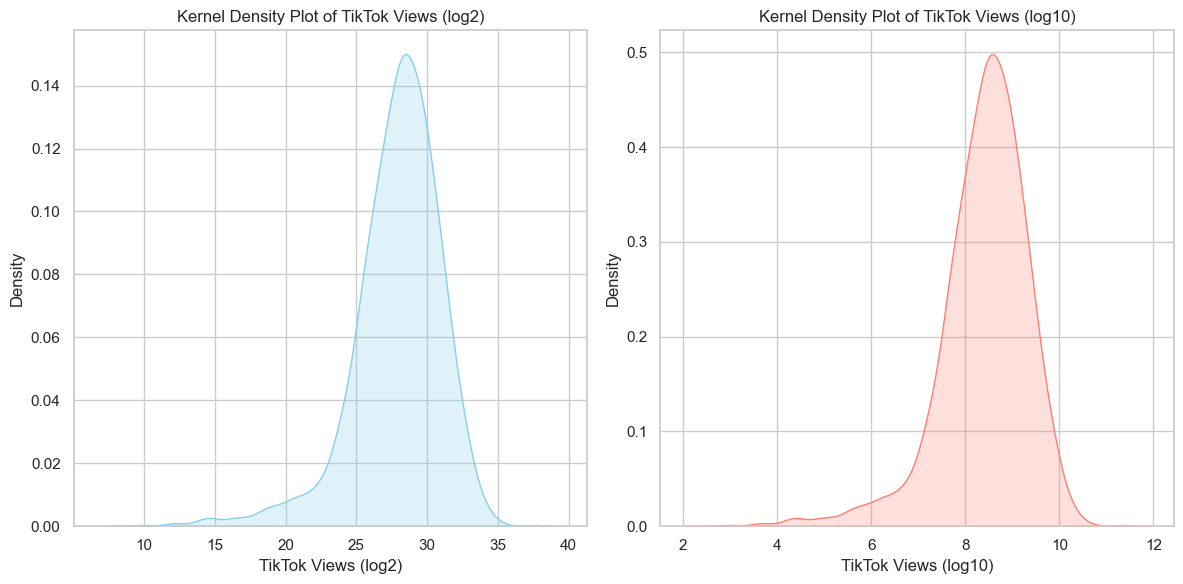


skewness log2 transform TikTok Views: -1.3094092954720524
skewness log10 transform TikTok Views: -1.3094092954720487
kurtosis log2 transform TikTok Views: 3.7886024436904
kurtosis log10 transform TikTok Views: 3.788602443690392


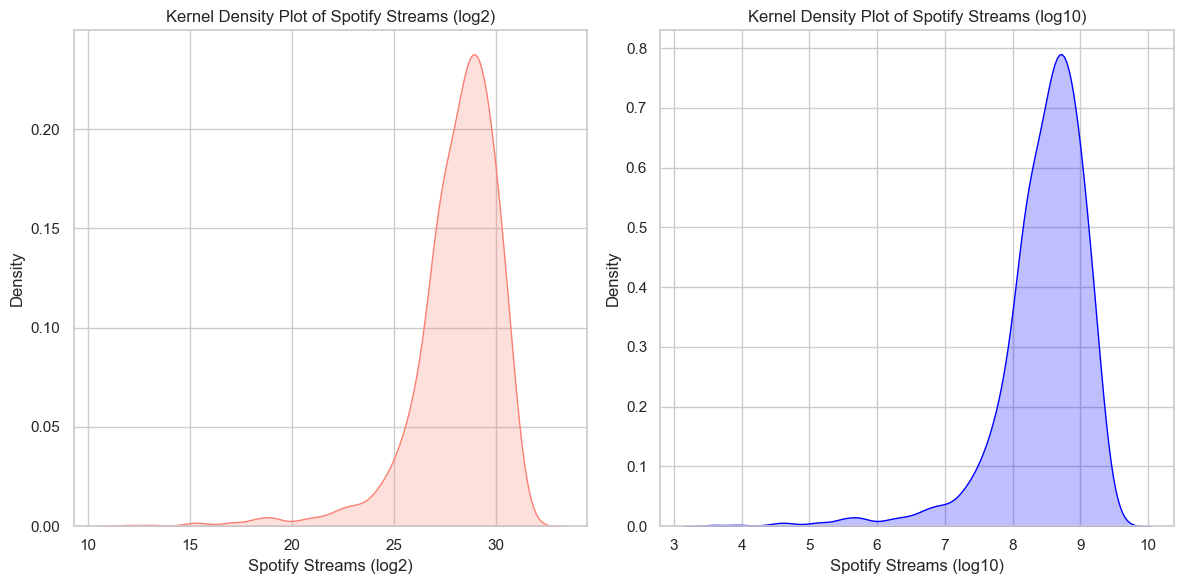


skewness log2 transform Spotify Streams: -2.29542456428495
skewness log10 transform Spotify Streams: -2.295424564284952
kurtosis log2 transform Spotify Streams: 9.031625994539192
kurtosis log10 transform Spotify Streams: 9.0316259945392


In [146]:

# TikTok Views - log2 and log10
plt.figure(figsize=(12, 6))

# Kernel Density Plot - log2
plt.subplot(1, 2, 1)
sns.kdeplot(spotify_songs['TikTok_Views_log2'], fill=True, color='skyblue')
plt.title('Kernel Density Plot of TikTok Views (log2)')
plt.xlabel('TikTok Views (log2)')
plt.ylabel('Density')
plt.grid(True)

# Kernel Density Plot - log10
plt.subplot(1, 2, 2)
sns.kdeplot(spotify_songs['TikTok_Views_log10'], fill=True, color='salmon')
plt.title('Kernel Density Plot of TikTok Views (log10)')
plt.xlabel('TikTok Views (log10)')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate the skewness
print('\nskewness log2 transform TikTok Views:', str(skew(spotify_songs.TikTok_Views_log2, axis=0, bias=True)))
print('skewness log10 transform TikTok Views:', str(skew(spotify_songs.TikTok_Views_log10, axis=0, bias=True)))

# Calculate the kurtosis
print('kurtosis log2 transform TikTok Views:', str(kurtosis(spotify_songs.TikTok_Views_log2, axis=0, bias=True)))
print('kurtosis log10 transform TikTok Views:', str(kurtosis(spotify_songs.TikTok_Views_log10, axis=0, bias=True)))

# Spotify Streams - log2 and log10
plt.figure(figsize=(12, 6))

# Kernel Density Plot - log2
plt.subplot(1, 2, 1)
sns.kdeplot(spotify_songs['Spotify_Streams_log2'], fill=True, color='salmon')
plt.title('Kernel Density Plot of Spotify Streams (log2)')
plt.xlabel('Spotify Streams (log2)')
plt.ylabel('Density')
plt.grid(True)

# Kernel Density Plot - log10
plt.subplot(1, 2, 2)
sns.kdeplot(spotify_songs['Spotify_Streams_log10'], fill=True, color='blue')
plt.title('Kernel Density Plot of Spotify Streams (log10)')
plt.xlabel('Spotify Streams (log10)')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate the skewness
print('\nskewness log2 transform Spotify Streams:', str(skew(spotify_songs.Spotify_Streams_log2, axis=0, bias=True)))
print('skewness log10 transform Spotify Streams:', str(skew(spotify_songs.Spotify_Streams_log10, axis=0, bias=True)))

# Calculate the kurtosis
print('kurtosis log2 transform Spotify Streams:', str(kurtosis(spotify_songs.Spotify_Streams_log2, axis=0, bias=True)))
print('kurtosis log10 transform Spotify Streams:', str(kurtosis(spotify_songs.Spotify_Streams_log10, axis=0, bias=True)))



#### 3.4.2 Correlations

##### Scatter plots

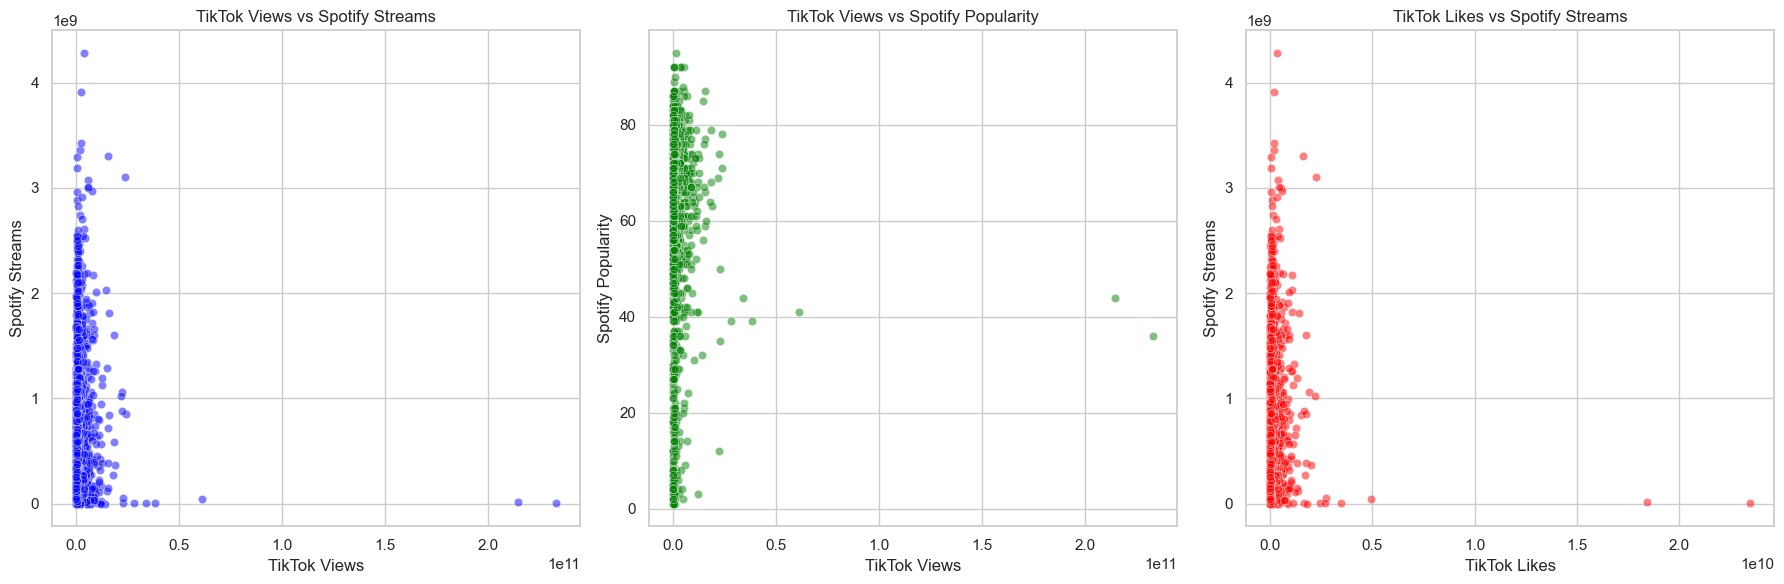

In [147]:


# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure and axis objects
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot of TikTok Views vs Spotify Streams
sns.scatterplot(x=spotify_songs['TikTok_Views'], y=spotify_songs['Spotify_Streams'], 
                ax=axes[0], color='blue', alpha=0.5)
axes[0].set_title('TikTok Views vs Spotify Streams')
axes[0].set_xlabel('TikTok Views')
axes[0].set_ylabel('Spotify Streams')

# Scatter plot of TikTok Views vs Spotify Popularity
sns.scatterplot(x=spotify_songs['TikTok_Views'], y=spotify_songs['Spotify_Popularity'], 
                ax=axes[1], color='green', alpha=0.5)
axes[1].set_title('TikTok Views vs Spotify Popularity')
axes[1].set_xlabel('TikTok Views')
axes[1].set_ylabel('Spotify Popularity')

# Scatter plot of TikTok Likes vs Spotify Streams
sns.scatterplot(x=spotify_songs['TikTok_Likes'], y=spotify_songs['Spotify_Streams'], 
                ax=axes[2], color='red', alpha=0.5)
axes[2].set_title('TikTok Likes vs Spotify Streams')
axes[2].set_xlabel('TikTok Likes')
axes[2].set_ylabel('Spotify Streams')

# Display the plots
plt.tight_layout()
plt.show()



##### Log-Log Scatter plots

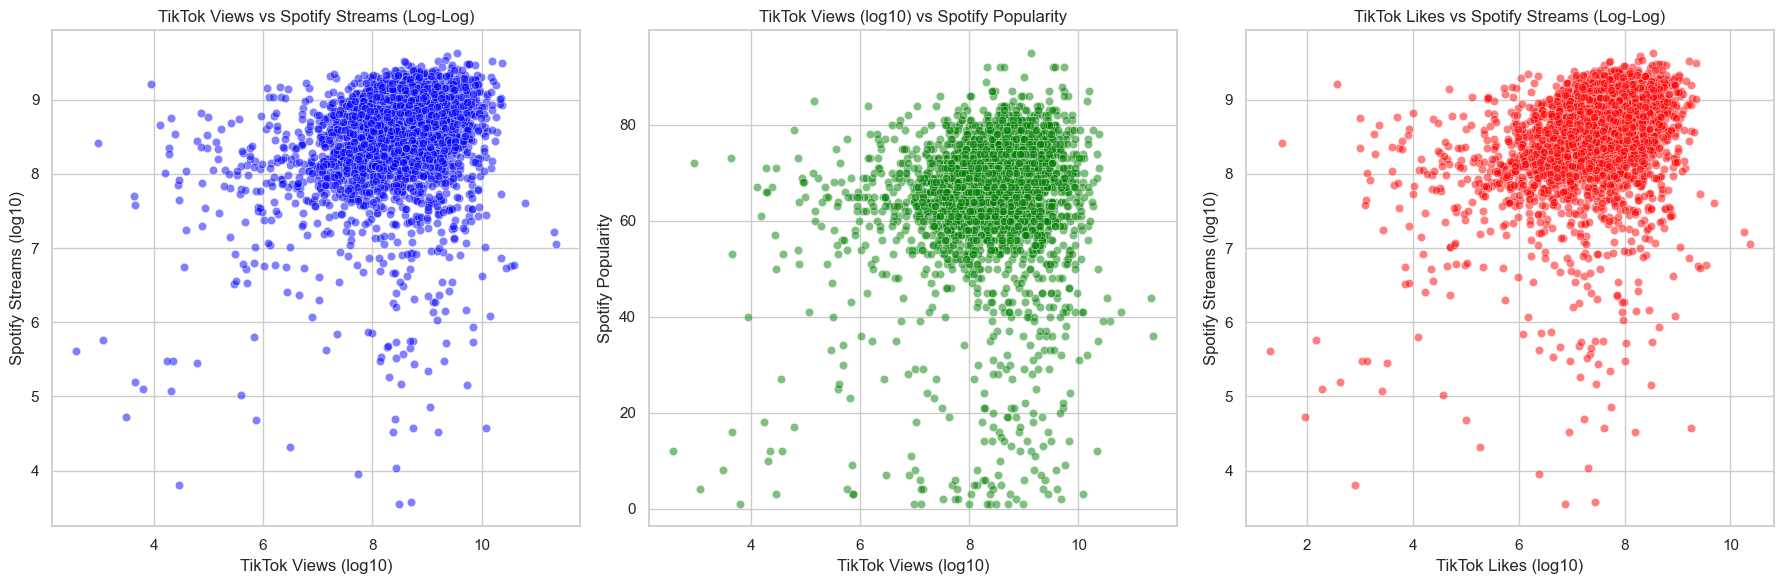

In [148]:


# Create log-log scatter plots for better visualization of relationships
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Log-Log: TikTok Views vs Spotify Streams
sns.scatterplot(x=spotify_songs['TikTok_Views_log10'], y=spotify_songs['Spotify_Streams_log10'], 
                ax=axes[0], color='blue', alpha=0.5)
axes[0].set_title('TikTok Views vs Spotify Streams (Log-Log)')
axes[0].set_xlabel('TikTok Views (log10)')
axes[0].set_ylabel('Spotify Streams (log10)')

# Log-Log: TikTok Views vs Spotify Popularity
sns.scatterplot(x=spotify_songs['TikTok_Views_log10'], y=spotify_songs['Spotify_Popularity'], 
                ax=axes[1], color='green', alpha=0.5)
axes[1].set_title('TikTok Views (log10) vs Spotify Popularity')
axes[1].set_xlabel('TikTok Views (log10)')
axes[1].set_ylabel('Spotify Popularity')

# Log-Log: TikTok Likes vs Spotify Streams  
spotify_songs['TikTok_Likes_log10'] = np.log10(spotify_songs['TikTok_Likes'])
sns.scatterplot(x=spotify_songs['TikTok_Likes_log10'], y=spotify_songs['Spotify_Streams_log10'], 
                ax=axes[2], color='red', alpha=0.5)
axes[2].set_title('TikTok Likes vs Spotify Streams (Log-Log)')
axes[2].set_xlabel('TikTok Likes (log10)')
axes[2].set_ylabel('Spotify Streams (log10)')

# Display the plots
plt.tight_layout()
plt.show()


##### Covariance

In [149]:

print("\nCovariance Matrix (Spotify Streams, TikTok Views, Spotify Popularity, TikTok Likes):")
print(spotify_songs[['Spotify_Streams', 'TikTok_Views', 'Spotify_Popularity', 'TikTok_Likes']].cov())



Covariance Matrix (Spotify Streams, TikTok Views, Spotify Popularity, TikTok Likes):
                    Spotify_Streams  TikTok_Views  Spotify_Popularity  \
Spotify_Streams        2.948791e+17  6.727976e+16        3.497745e+09   
TikTok_Views           6.727976e+16  3.850998e+19       -5.114931e+09   
Spotify_Popularity     3.497745e+09 -5.114931e+09        1.888444e+02   
TikTok_Likes           1.044385e+16  3.574740e+18       -3.762014e+08   

                    TikTok_Likes  
Spotify_Streams     1.044385e+16  
TikTok_Views        3.574740e+18  
Spotify_Popularity -3.762014e+08  
TikTok_Likes        3.366998e+17  


##### Correlation coefficients (Pearson vs. Spearmann)

In [150]:


# Select key variables for correlation analysis
key_vars = ['Spotify_Streams', 'Spotify_Popularity', 'TikTok_Views', 'TikTok_Likes']

# Compute the Pearson correlation matrix
pearson_corr = spotify_songs[key_vars].corr(method='pearson')

# Compute the Spearman correlation matrix
spearman_corr = spotify_songs[key_vars].corr(method='spearman')

# Print the correlation matrices
print("\nPearson Correlation Matrix:")
print(pearson_corr, "\n")

print("Spearman Correlation Matrix:")
print(spearman_corr)




Pearson Correlation Matrix:
                    Spotify_Streams  Spotify_Popularity  TikTok_Views  \
Spotify_Streams            1.000000            0.468721      0.019965   
Spotify_Popularity         0.468721            1.000000     -0.059979   
TikTok_Views               0.019965           -0.059979      1.000000   
TikTok_Likes               0.033145           -0.047179      0.992742   

                    TikTok_Likes  
Spotify_Streams         0.033145  
Spotify_Popularity     -0.047179  
TikTok_Views            0.992742  
TikTok_Likes            1.000000   

Spearman Correlation Matrix:
                    Spotify_Streams  Spotify_Popularity  TikTok_Views  \
Spotify_Streams            1.000000            0.671682      0.261490   
Spotify_Popularity         0.671682            1.000000      0.142749   
TikTok_Views               0.261490            0.142749      1.000000   
TikTok_Likes               0.325141            0.191967      0.980455   

                    TikTok_Likes 

##### Correlation Plots

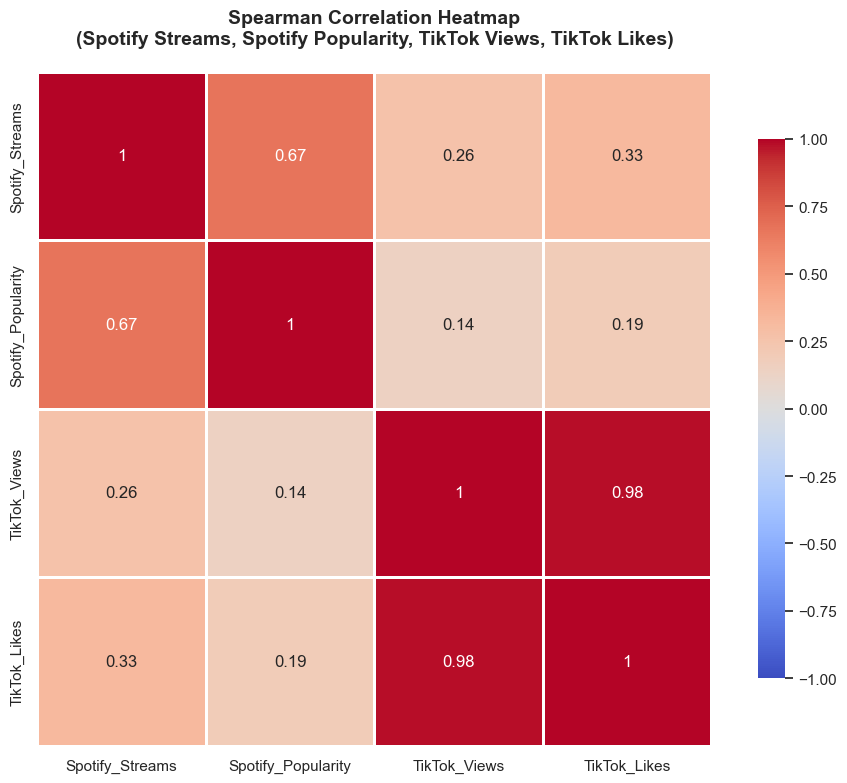

In [151]:

# Compute the Spearman correlation matrix (chosen method)
correlation_matrix = spotify_songs[key_vars].corr(method='spearman')  # use pearson for Pearson correlation

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})

# Set the title and labels
plt.title('Spearman Correlation Heatmap\n(Spotify Streams, Spotify Popularity, TikTok Views, TikTok Likes)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

#### 3.4.3 Summary statistics table

In [152]:

# Select relevant columns
data = spotify_songs[['Spotify_Streams', 'Spotify_Popularity', 'TikTok_Views', 'TikTok_Likes']]

# Calculate summary statistics
summary_stats = data.describe().T[['count', 'mean', 'std', 'min', 'max']]

# Calculate correlations with other variables (using Spearman due to skewness)
correlations = data.corr(method='spearman')

# Merge summary statistics and correlation information
summary_table = summary_stats.join(correlations, lsuffix='_stat')

# Rename the columns for clarity
summary_table.columns = [
    'N',
    'Mean', 
    'S.D.',
    'Min',
    'Max',
    '(1)',
    '(2)',
    '(3)',
    '(4)'
]

# Rename row index
summary_table = summary_table.rename(index={
    'Spotify_Streams': "(1) Spotify Streams",
    'Spotify_Popularity': "(2) Spotify Popularity", 
    'TikTok_Views': "(3) TikTok Views",
    'TikTok_Likes': "(4) TikTok Likes"
})

# Print the summary table
summary_table = np.round(summary_table, 2)
print(summary_table)


                             N          Mean          S.D.     Min  \
(1) Spotify Streams     3159.0  5.483810e+08  5.430277e+08  3574.0   
(2) Spotify Popularity  3159.0  6.455000e+01  1.374000e+01     1.0   
(3) TikTok Views        3159.0  1.249347e+09  6.205641e+09   385.0   
(4) TikTok Likes        3159.0  1.220438e+08  5.802584e+08    20.0   

                                 Max   (1)   (2)   (3)   (4)  
(1) Spotify Streams     4.281469e+09  1.00  0.67  0.26  0.33  
(2) Spotify Popularity  9.500000e+01  0.67  1.00  0.14  0.19  
(3) TikTok Views        2.332323e+11  0.26  0.14  1.00  0.98  
(4) TikTok Likes        2.347422e+10  0.33  0.19  0.98  1.00  


all variables:

In [153]:
# Select all relevant columns
data_full = spotify_songs[['Spotify_Streams', 'Spotify_Popularity', 'Spotify_Playlist_Count',
                            'TikTok_Posts', 'TikTok_Likes', 'TikTok_Views', 'Track_Score']]

# Calculate summary statistics
summary_stats_full = data_full.describe().T[['count', 'mean', 'std', 'min', 'max']]

# Calculate correlations (Spearman)
correlations_full = data_full.corr(method='spearman')

# Merge summary statistics and correlation information
summary_table_full = summary_stats_full.join(correlations_full, lsuffix='_stat')

# Rename the columns for clarity
summary_table_full.columns = [
    'N',
    'Mean',
    'S.D.',
    'Min',
    'Max',
    '(1)',
    '(2)',
    '(3)',
    '(4)',
    '(5)',
    '(6)',
    '(7)'
]

# Rename row index
summary_table_full = summary_table_full.rename(index={
    'Spotify_Streams': "(1) Spotify Streams",
    'Spotify_Popularity': "(2) Spotify Popularity",
    'Spotify_Playlist_Count': "(3) Spotify Playlists",
    'TikTok_Posts': "(4) TikTok Posts",
    'TikTok_Likes': "(5) TikTok Likes",
    'TikTok_Views': "(6) TikTok Views",
    'Track_Score': "(7) Track Score"
})

# Round the summary table
summary_table_full = np.round(summary_table_full, 2)
print(summary_table_full)


                             N          Mean          S.D.     Min  \
(1) Spotify Streams     3159.0  5.483810e+08  5.430277e+08  3574.0   
(2) Spotify Popularity  3159.0  6.455000e+01  1.374000e+01     1.0   
(3) Spotify Playlists   3159.0  8.077640e+04  7.446230e+04     1.0   
(4) TikTok Posts        3159.0  9.326539e+05  2.356717e+06     1.0   
(5) TikTok Likes        3159.0  1.220438e+08  5.802584e+08    20.0   
(6) TikTok Views        3159.0  1.249347e+09  6.205641e+09   385.0   
(7) Track Score         3159.0  4.240000e+01  3.919000e+01    19.4   

                                 Max   (1)   (2)   (3)   (4)   (5)   (6)   (7)  
(1) Spotify Streams     4.281469e+09  1.00  0.67  0.88  0.21  0.33  0.26  0.35  
(2) Spotify Popularity  9.500000e+01  0.67  1.00  0.58  0.03  0.19  0.14  0.39  
(3) Spotify Playlists   5.903920e+05  0.88  0.58  1.00  0.15  0.31  0.25  0.28  
(4) TikTok Posts        3.772646e+07  0.21  0.03  0.15  1.00  0.81  0.85  0.32  
(5) TikTok Likes        2.347422e+